# CD7: full spectrum dimensionality reduction of neutrophils

In this notebook, we perform a clustering analysis of the CD7 data on features extracted from SCIP.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
from scip_workflows.common import *

In [4]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import scale
import anndata
import scanpy
scanpy.settings.verbosity = 3

from sklearn.preprocessing import scale
import flowutils

import scipy.stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

from kneed import KneeLocator

In [5]:
from scip.features import intensity
props = intensity.props.copy()
props.remove("kurtosis")
props.remove("skewness")

In [6]:
def asinh_scale(x, t):
    return scale(flowutils.transforms.asinh(x, channel_indices=None, t=t, m=4.5, a=1), with_std=False)

In [7]:
plt.rcParams['figure.dpi'] = 150

## Data

In [255]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    fillna = bool(int(snakemake.wildcards.fillna))
    output = snakemake.output[0]
except NameError:
    data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/cd7/800/scip/150920221347/")
    features = data_dir / "features.parquet"
    index = data_dir / "indices" / "index.npy"
    columns = data_dir / "indices" / "columns.npy"
    fillna = False
    output = data_dir / f"adata_{int(fillna)}.h5ad"

In [179]:
df = pq.read_table(features).to_pandas()
df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.loc["D"]
df = df[[c for c in numpy.load(columns, allow_pickle=True) if c in df.columns]]
df = df.loc[numpy.load(index, allow_pickle=True)]
df = df.sort_index()

df.shape

(31017, 1186)

## Removing zero variance features

from sklearn.feature_selection import VarianceThreshold

In [180]:
var = VarianceThreshold().fit(df.filter(regex="feat"))

In [181]:
df = pandas.concat([
    df.filter(regex="feat").iloc[:, var.get_support()],
    df.filter(regex="meta")
], axis=1)

## NaN values

In [182]:
df.isna().all(axis=0).any()

False

In [183]:
df.filter(regex="feat").isna().all(axis=1).sum()

0

<AxesSubplot:ylabel='Count'>

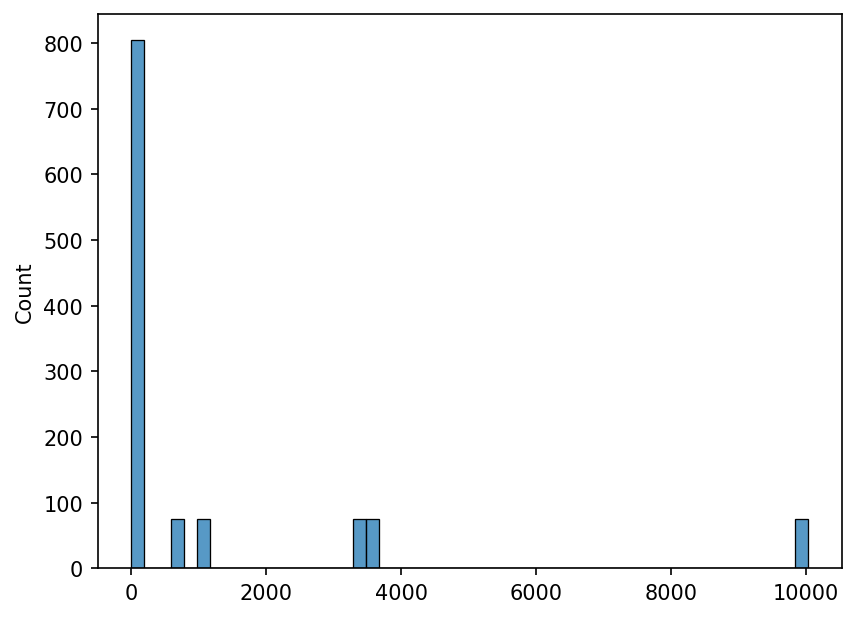

In [184]:
seaborn.histplot(data=df.isna().sum())

In [186]:
if fillna:
    df = df.fillna(0)
else:
    df = df.drop(columns=df.columns[df.isna().sum() > 0])

## Analysis

In [187]:
obs = df.filter(regex='meta').reset_index()
obs.index = df.index
adata = anndata.AnnData(df.filter(regex="feat").astype(numpy.float32), obs=obs)

adata.obs["meta_replicate"] = adata.obs["meta_replicate"].astype("category")

In [188]:
markers = [col for col in adata.var.index if col.startswith("feat_sum")]

In [189]:
adata_pre = adata.copy()

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:43)


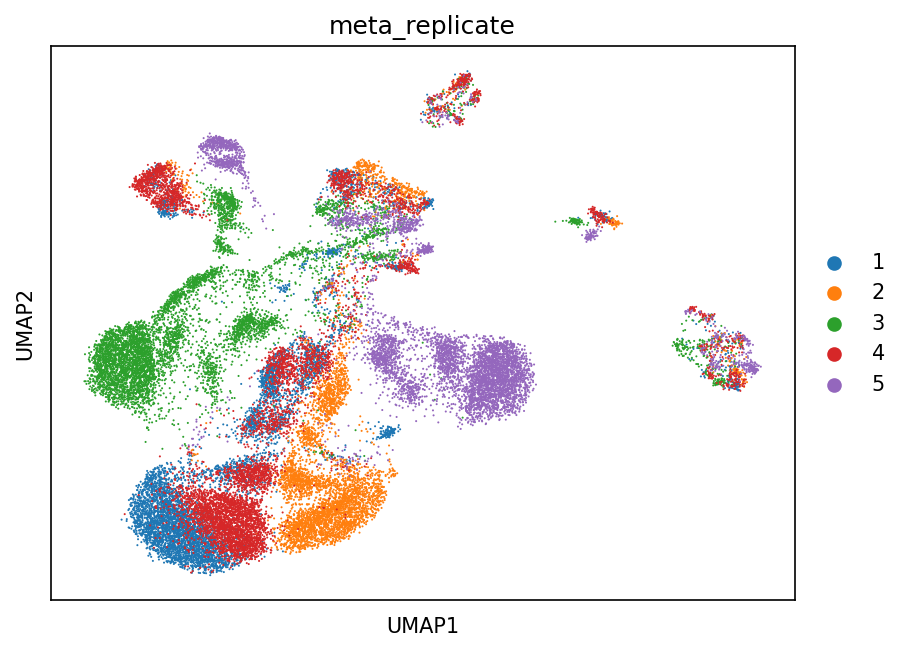

CPU times: user 2min 5s, sys: 12.9 s, total: 2min 18s
Wall time: 55 s


In [190]:
%%time
scanpy.pp.scale(adata_pre)
scanpy.tl.pca(adata_pre, svd_solver='arpack')
scanpy.pp.neighbors(adata_pre, n_neighbors=30)
scanpy.tl.umap(adata_pre)
scanpy.pl.umap(adata_pre, color=["meta_replicate"])

In [191]:
discrete = ["median", "area", "euler"]
discrete_cols = [c for c in adata.var_names if any(d in c for d in discrete)]
discrete_cols_i = [i for i, c in enumerate(adata.var_names) if any(d in c for d in discrete)]

In [192]:
adata.var["is_marker"] = [any(n.endswith("feat_combined_sum_%s" % m) for m in ["DAPI", "EGFP", "RPe", "APC"]) for n in adata.var_names]
adata.var["do_asinh"] = [(any(m in n for m in ["DAPI", "EGFP", "RPe", "APC"]) and any(o in n for o in props)) for n in adata.var_names]

In [193]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sc_df = scanpy.get.obs_df(adata, keys=adata.var_names.to_list())
    sc_df[adata.var_names[adata.var.do_asinh].to_list()] = sc_df[adata.var_names[adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: asinh_scale(x, x.max()))
    sc_df[adata.var_names[~adata.var.do_asinh].to_list()] = sc_df[adata.var_names[~adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: scale(x))

adata = anndata.AnnData(X=sc_df, obs=adata.obs, var=adata.var)

CPU times: user 2min, sys: 1min 3s, total: 3min 4s
Wall time: 3min 4s


In [194]:
def map_names(a):
    return {
        "feat_combined_sum_DAPI": "DAPI",
        "feat_combined_sum_EGFP": "CD45",
        "feat_combined_sum_RPe": "Siglec 8",
        "feat_combined_sum_APC": "CD15"
    }[a]

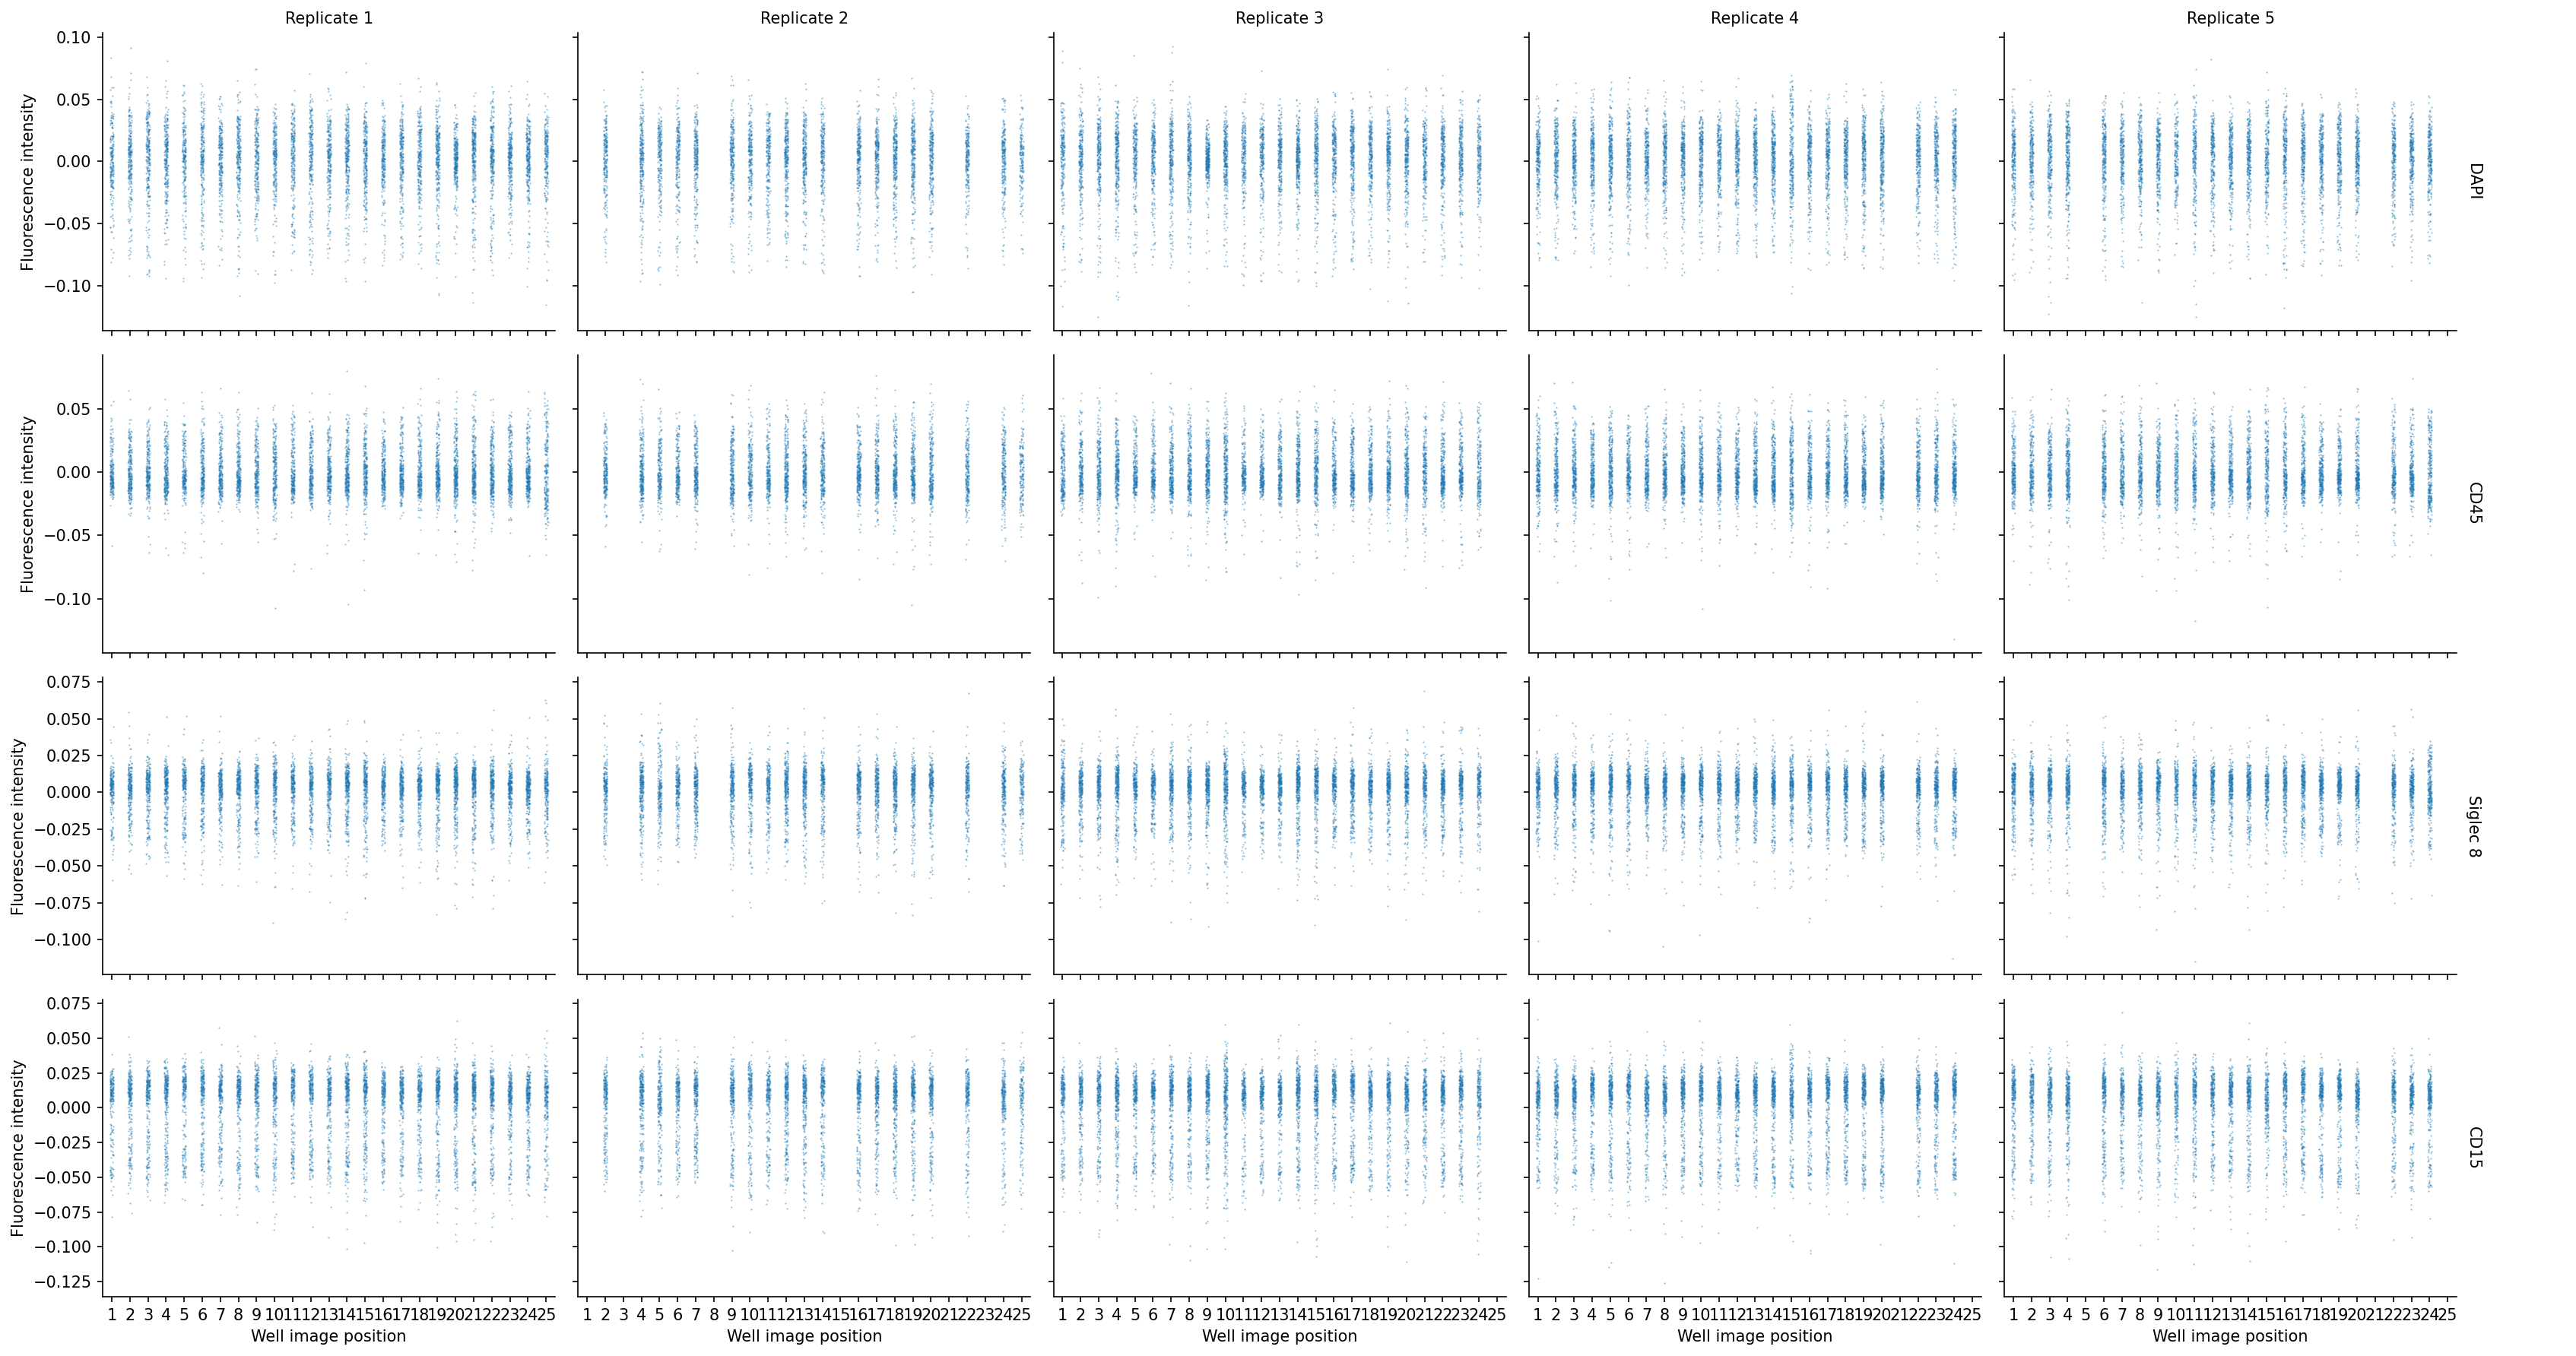

In [195]:
aligned_df = scanpy.get.obs_df(adata, keys=adata.var_names[adata.var.is_marker].to_list()).reset_index()

melted_df = pandas.melt(aligned_df, id_vars=["meta_P", "meta_replicate"], value_vars=adata.var_names[adata.var.is_marker].to_list())
melted_df.variable = melted_df.variable.apply(map_names)

grid = seaborn.FacetGrid(data=melted_df, col="meta_replicate", row="variable", sharey="row", aspect=1.5, margin_titles=True)
grid.map_dataframe(seaborn.stripplot, x="meta_P", y="value", size=1, alpha=0.5)

grid.set_axis_labels("Well image position", "Fluorescence intensity")
grid.set_titles(col_template="Replicate {col_name}", row_template="{row_name}")

grid.add_legend()

# plt.savefig(data_dir / "figures/qc_intensity_distribution_post.png", bbox_inches='tight', pad_inches=0)

In [196]:
def rediscritize(v):
    bin_idx = numpy.digitize(v, bins=numpy.histogram_bin_edges(v))
    bin2mu = [numpy.mean(v[bin_idx == i]) for i in range(1, numpy.max(bin_idx)+1)]
    return numpy.fromiter((bin2mu[i-1] for i in bin_idx), dtype=float)

In [197]:
adata = adata[adata.to_df().isna().sum(axis=1) == 0].copy()

In [199]:
X = adata.X.copy()
X[:, discrete_cols_i] = numpy.apply_along_axis(rediscritize, 0, X[:, discrete_cols_i])

/srv/scratch/maximl/mambaforge/envs/scip/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/scratch/maximl/mambaforge/envs/scip/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [200]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    mi_post = mutual_info_classif(X=X, y=adata.obs["meta_replicate"], discrete_features=discrete_cols_i, n_neighbors=30, random_state=0)
    mi_post = pandas.Series(mi_post, index=adata.var_names).sort_values(ascending=False)

CPU times: user 4min 30s, sys: 1.72 s, total: 4min 32s
Wall time: 4min 32s


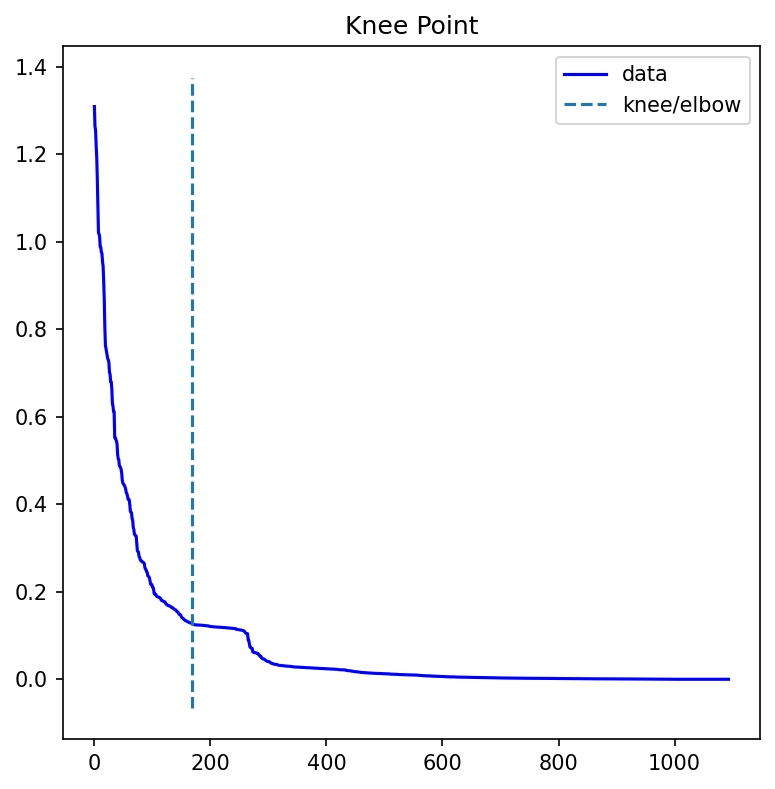

In [201]:
kneedle = KneeLocator(numpy.arange(len(mi_post)), mi_post, S=40, curve='convex', direction="decreasing",online=False)
elbow_value = mi_post.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [202]:
selected_mi = mi_post[mi_post < elbow_value].index.values
len(selected_mi) / len(mi_post)

0.8446069469835467

In [203]:
len(mi_post[mi_post > elbow_value].index.values)

169

In [204]:
adata2 = adata[:, selected_mi].copy()

In [205]:
scanpy.pp.scale(adata2)
scanpy.tl.pca(adata2, svd_solver='arpack')
scanpy.pp.neighbors(adata2, n_neighbors=30, method="umap")

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [206]:
%%time
resolutions = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]
for res in resolutions:
    scanpy.tl.leiden(adata2, resolution=res, key_added=f"leiden_{res}")

running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:09)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:09)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:16)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.75', the cluster labels (adata.obs, categorical) (0:00:16)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:18)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_1.25', the cluster labels (adata.obs, categorical) (0:00:21)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:21)
running Leiden cluster

In [207]:
scanpy.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:44)


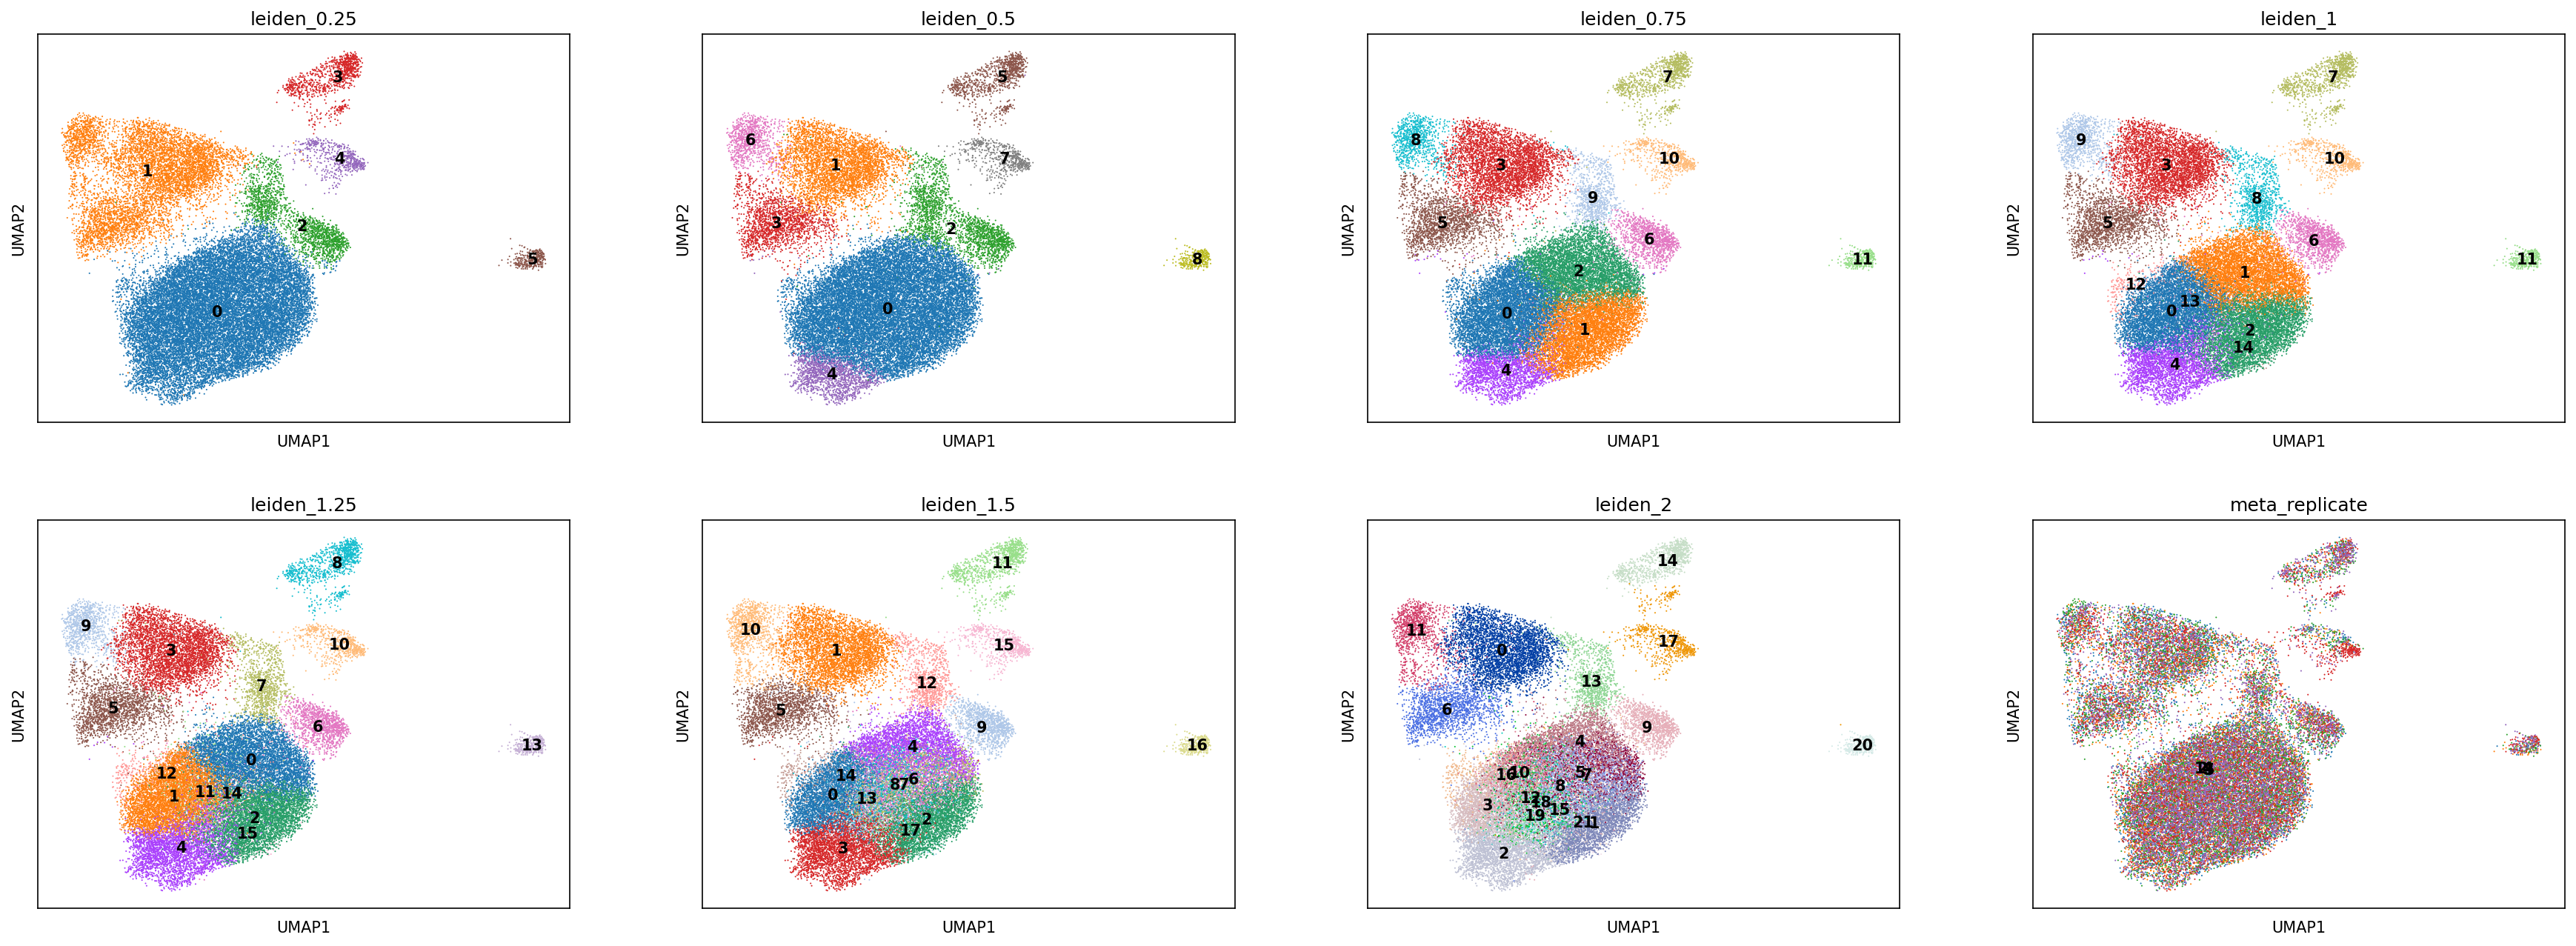

In [208]:
scanpy.pl.umap(adata2, color=["leiden_0.25", "leiden_0.5", "leiden_0.75", "leiden_1", "leiden_1.25", "leiden_1.5", "leiden_2", "meta_replicate"], legend_loc='on data')

In [209]:
adata2.obs["leiden"] = adata2.obs["leiden_0.5"]

<AxesSubplot:xlabel='leiden', ylabel='count'>

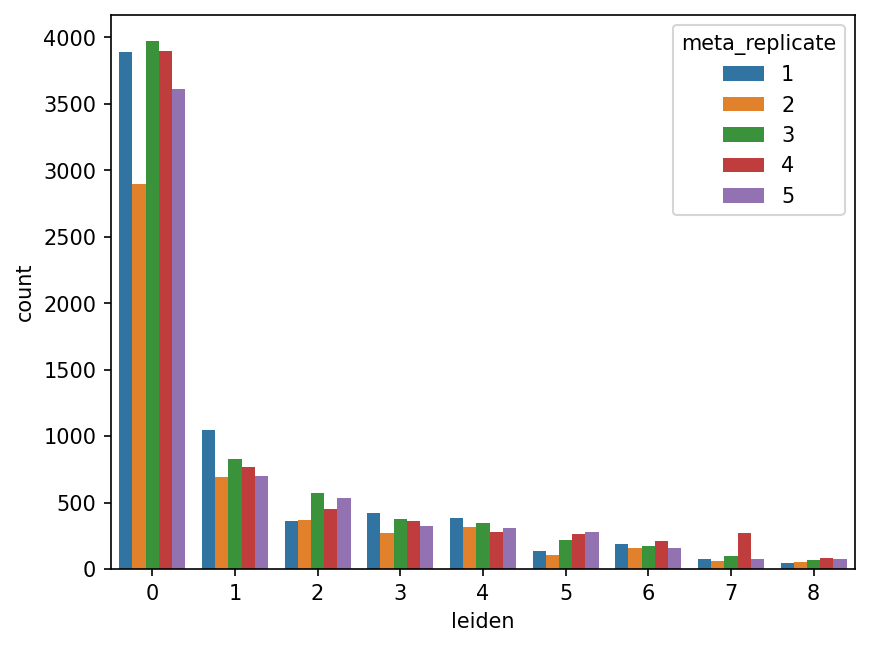

In [210]:
seaborn.countplot(data=adata2.obs, x="leiden", hue="meta_replicate")

In [211]:
markers = [col for col in adata2.var_names if col.startswith(tuple("feat_combined_sum_%s" % m for m in ("EGFP", "RPe", "APC", "DAPI")))]

In [212]:
scanpy.tl.dendrogram(adata2, groupby="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


<AxesSubplot:title={'center':'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

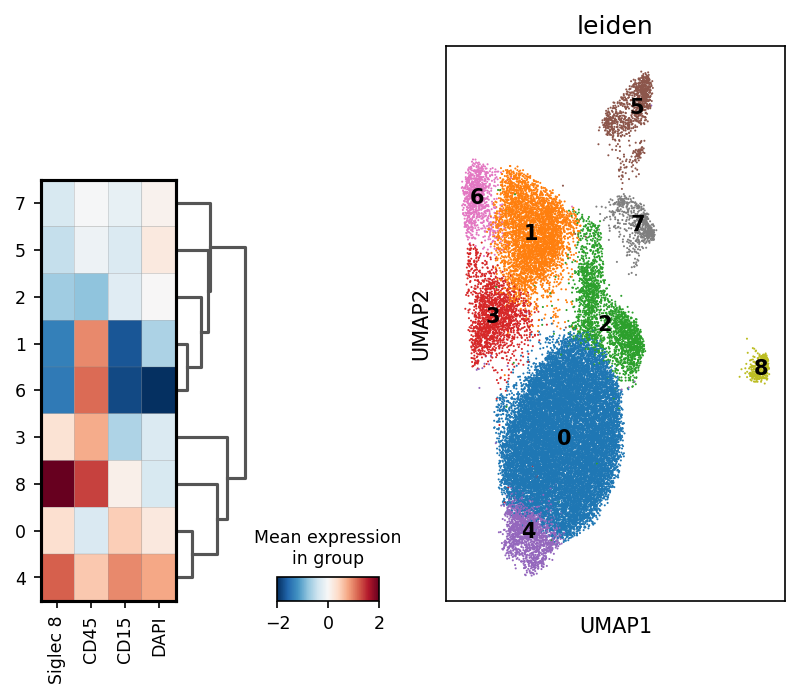

In [248]:
fig, axes = plt.subplots(1, 2)
ax = scanpy.pl.matrixplot(adata2, markers, groupby='leiden', dendrogram=True, vmin=-2, vmax=2, cmap='RdBu_r', ax=axes[0], show=False)
ax["mainplot_ax"].set_xticklabels(map(lambda a: map_names(a.get_text()), ax["mainplot_ax"].get_xticklabels()))
scanpy.pl.umap(adata2, color="leiden", legend_loc='on data', ax=axes[1], show=False)

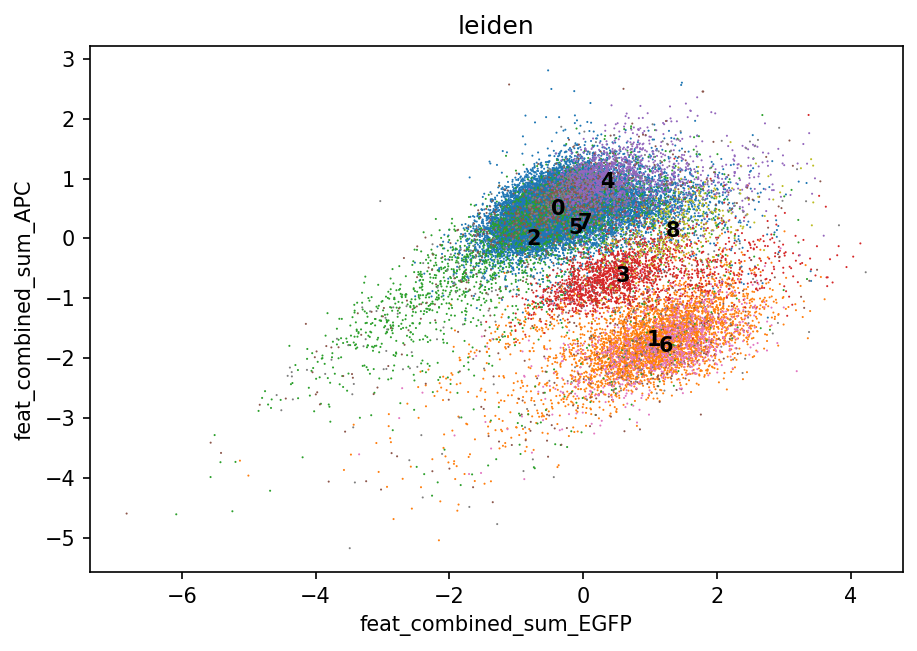

In [214]:
scanpy.pl.scatter(adata2, x="feat_combined_sum_EGFP", y="feat_combined_sum_APC", color="leiden", legend_loc="on data")

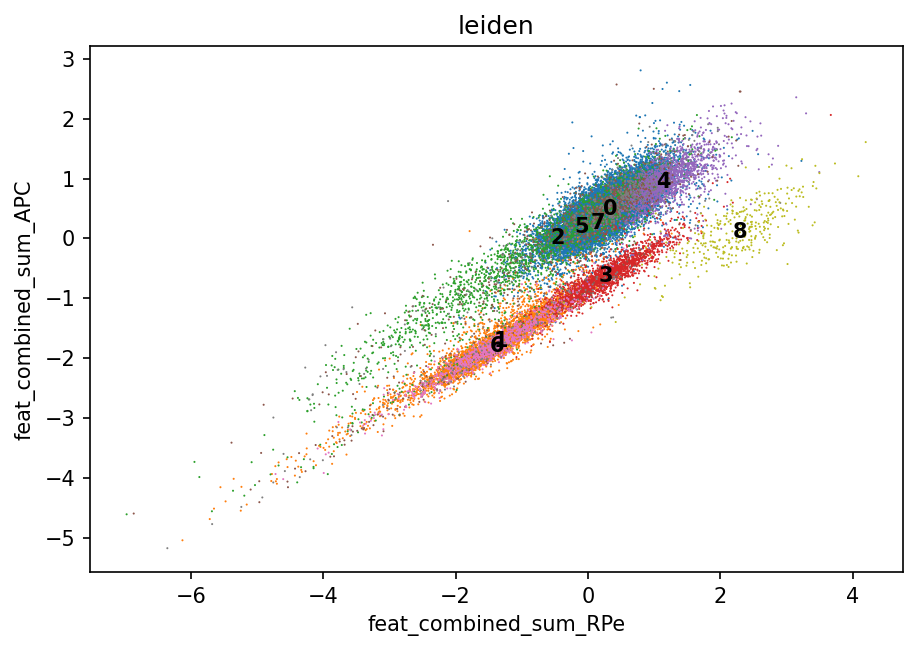

In [216]:
scanpy.pl.scatter(adata2, x="feat_combined_sum_RPe", y="feat_combined_sum_APC", color="leiden", legend_loc="on data")

In [267]:
adata_out = adata2.copy()
adata_out.obs = adata_out.obs.reset_index(drop=True)
adata_out.write_h5ad(output)